In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load fNIRS Dataset

Dataset Original Length n:  10401
Dataset Sampled Length n:  10401


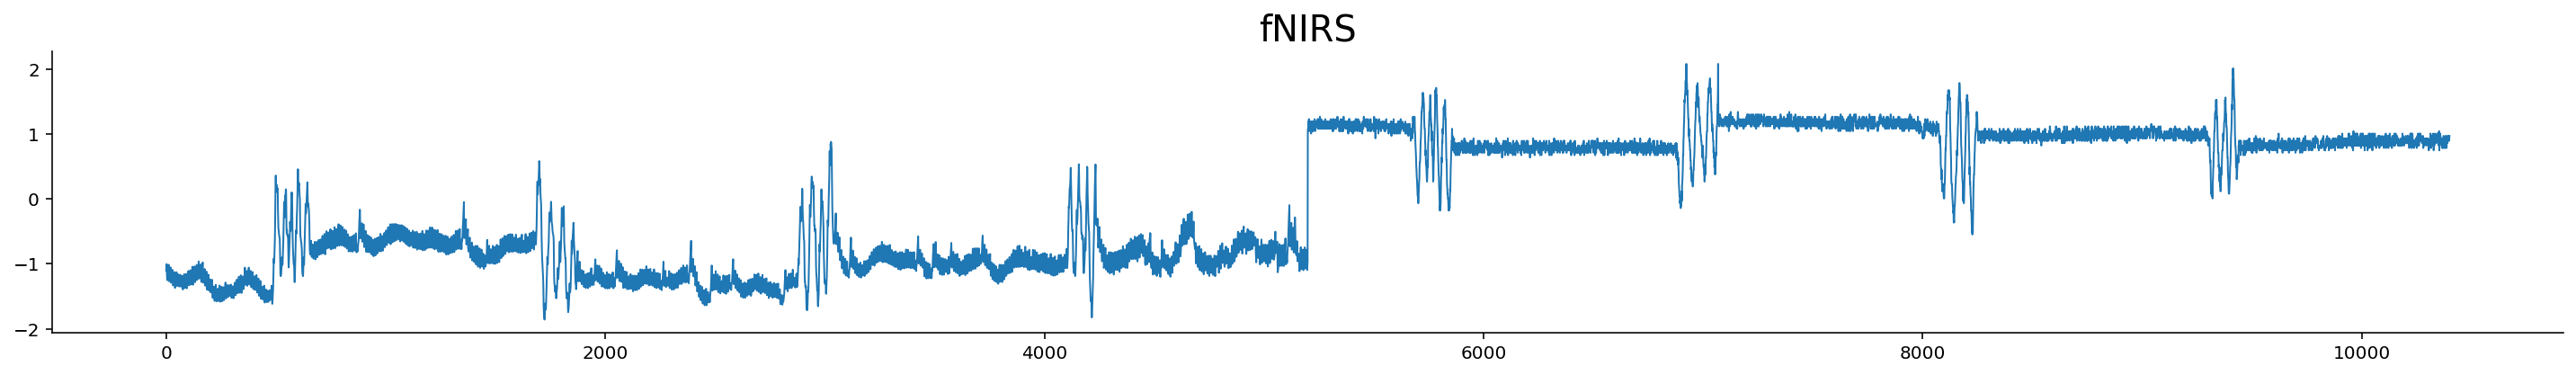

In [2]:
file = "fNIRS_subLen_600.csv" 
ds_name = "fNIRS"
series = ml.read_dataset_with_index(file) 
data = series.values
plot_dataset(file, series, ds_name=ds_name)

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2
df_comp = pd.DataFrame(columns=["Method", "Motif", "Extent", "k"]) # Complete Info

rerun_all_jars = False
motif_length = 160
ks = 20
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets/notebooks/../datasets/fNIRS_subLen_600.csv


# k-Motiflets

## First, we learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.39it/s]


Chosen window-size: 160
Identified Elbow Points [ 4  8 17]
Filtered Elbow Points [4, 17]


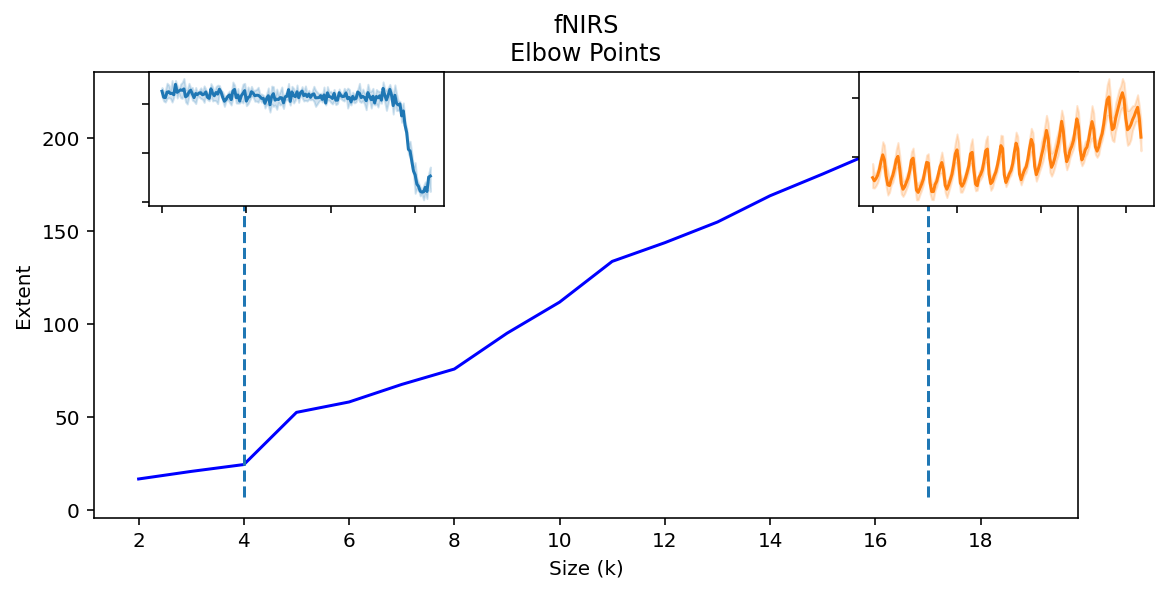

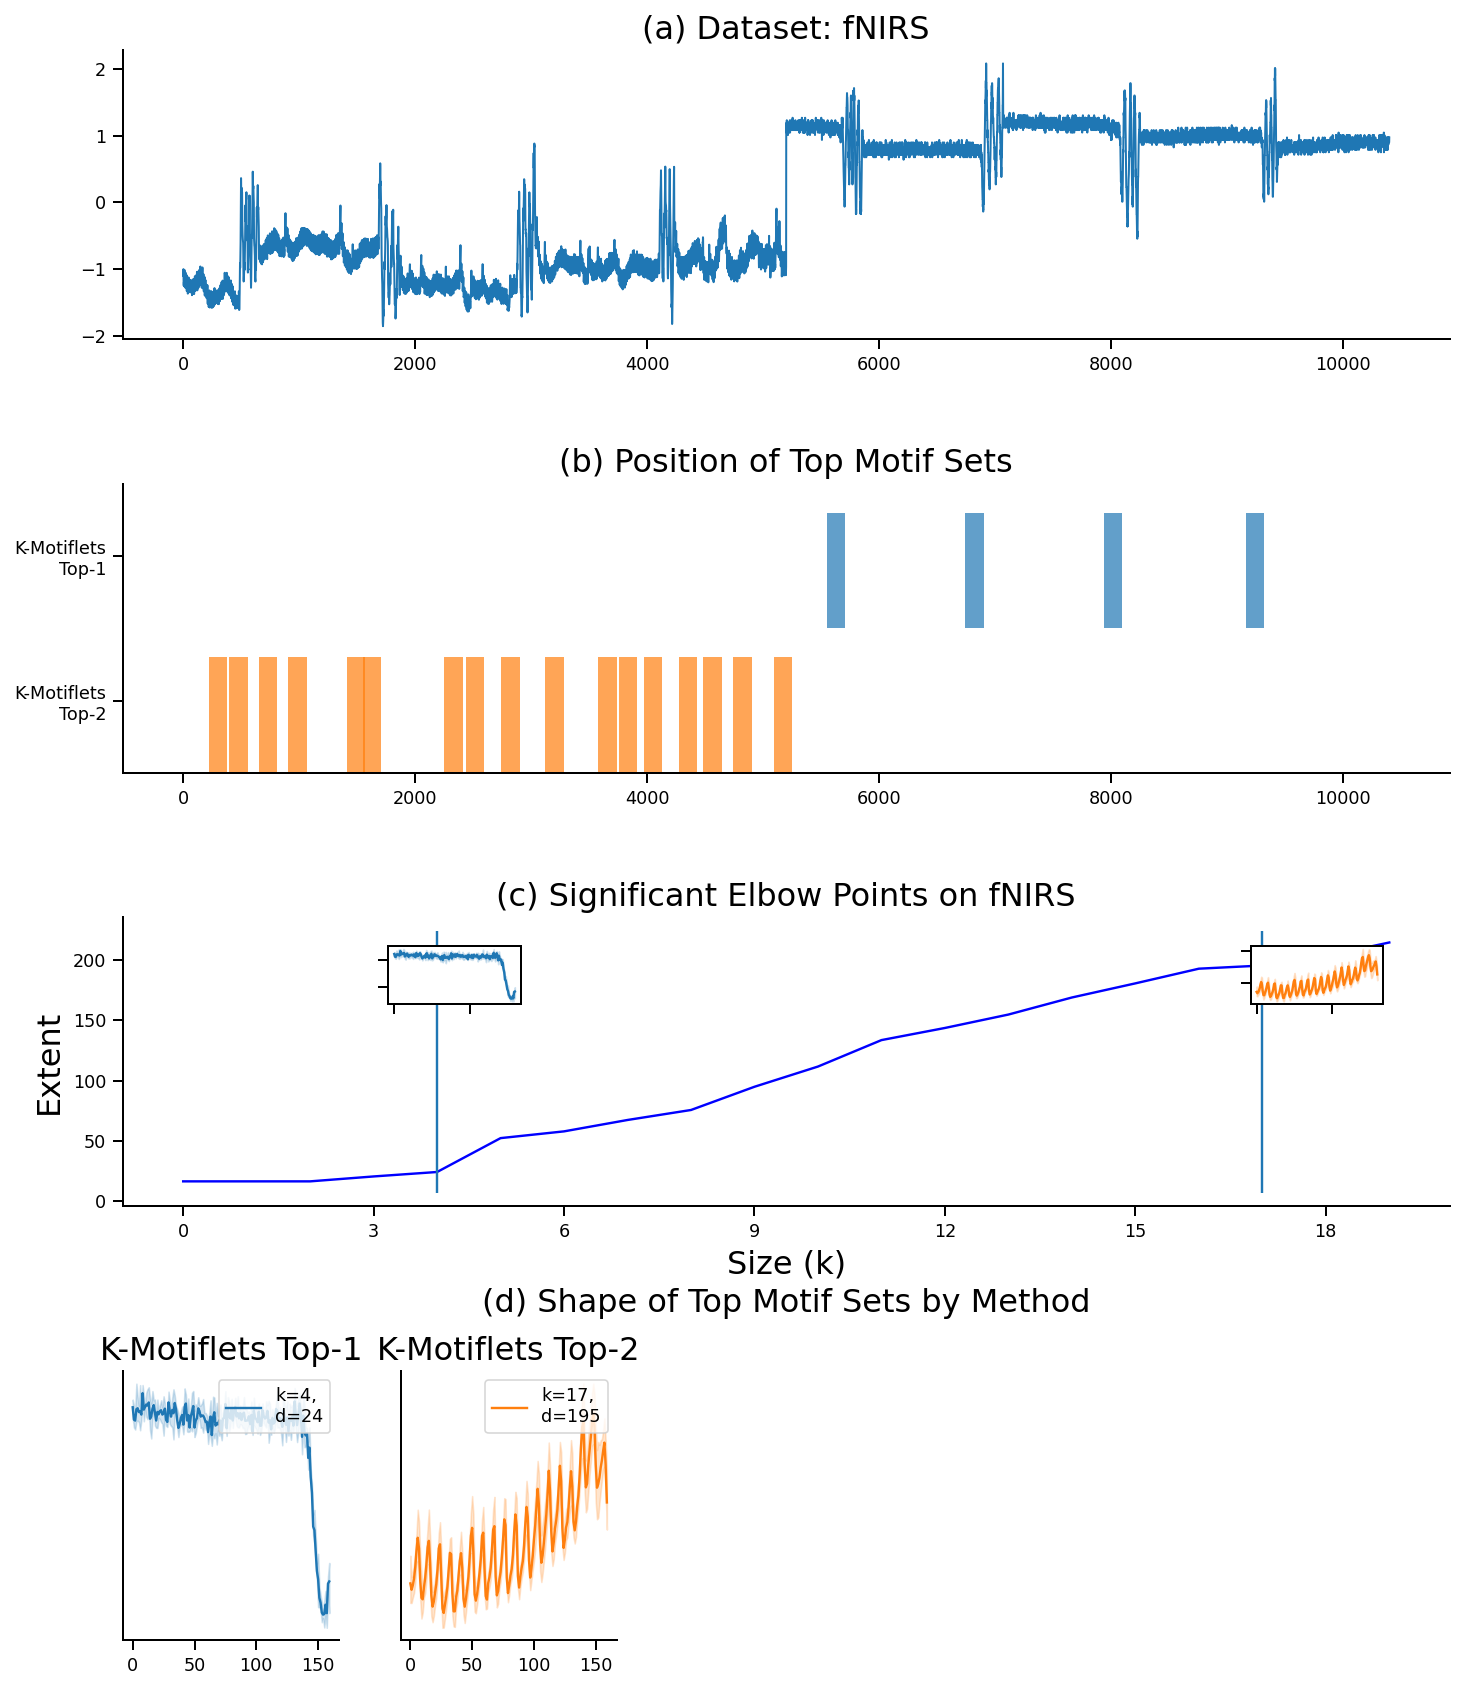

In [4]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, file, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets")

In [5]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]
df_comp = append_all_motif_sets(df_comp, motiflets, "Motiflets", D_full)
r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

Radius r of TOP-2 Motifs 120.5687026977539 21.33243751525879
Extent d of TOP-1 Motif 195.35789489746094


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error.

We pretend to have an oracle on the length l and the radius r. But this oracle is off by just 5% on both parameters to reflect human trial-and-error.

In [6]:
radii = np.array([r_top2, r_top1])
print("Radii r", radii)

# Human error due to trial-and-error
error = 0.05

rs = radii * (1.0*(1-error))
mls = np.int32(motif_length * (1+error))

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

print("Radii with human error\t", rs)
print("Length with human error\t", mls)

Radii r [ 21.33243752 120.5687027 ]
Best Radii	 [ 21.33243752 120.5687027 ]
Best Lengths	 160
Radii with human error	 [ 20.26581564 114.54026756]
Length with human error	 168


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [7]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs+1)),
       str(mls)])

r: 28.546472549438477 d: 28.546472549438477
r: 299.1433410644531 d: 313.5480651855469
Filtered Elbow Points [0, 1]


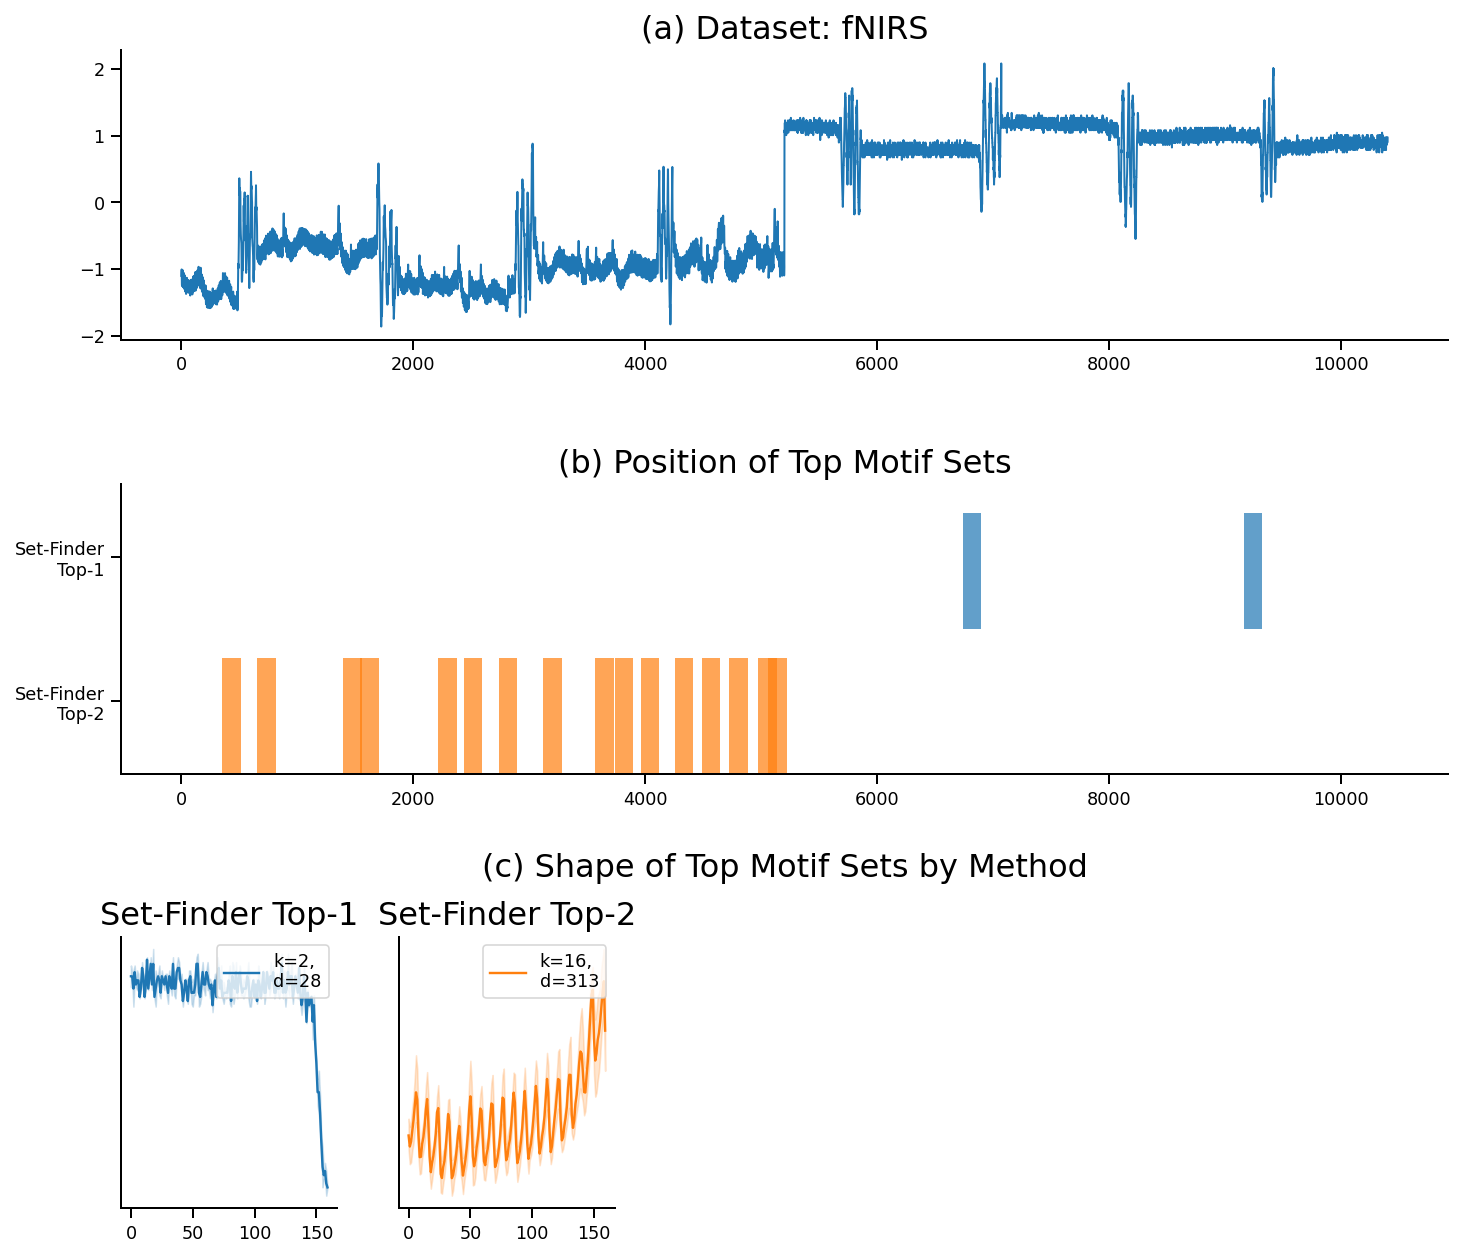

In [8]:
# run jave code first       
ms_set_finder = [
    [6739, 9159],
	[4486, 351, 654, 1394, 1542, 2215, 2434, 2735, 3121, 3570, 3738, 3961, 4254, 4724, 4975, 5059],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, prefix="Set-Finder")

df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_set_finder, "Set Finder", D_full)

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [9]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

r: 44.992000579833984 d: 44.992000579833984
r: 160.49139404296875 d: 226.93580627441406
Filtered Elbow Points [0, 1]


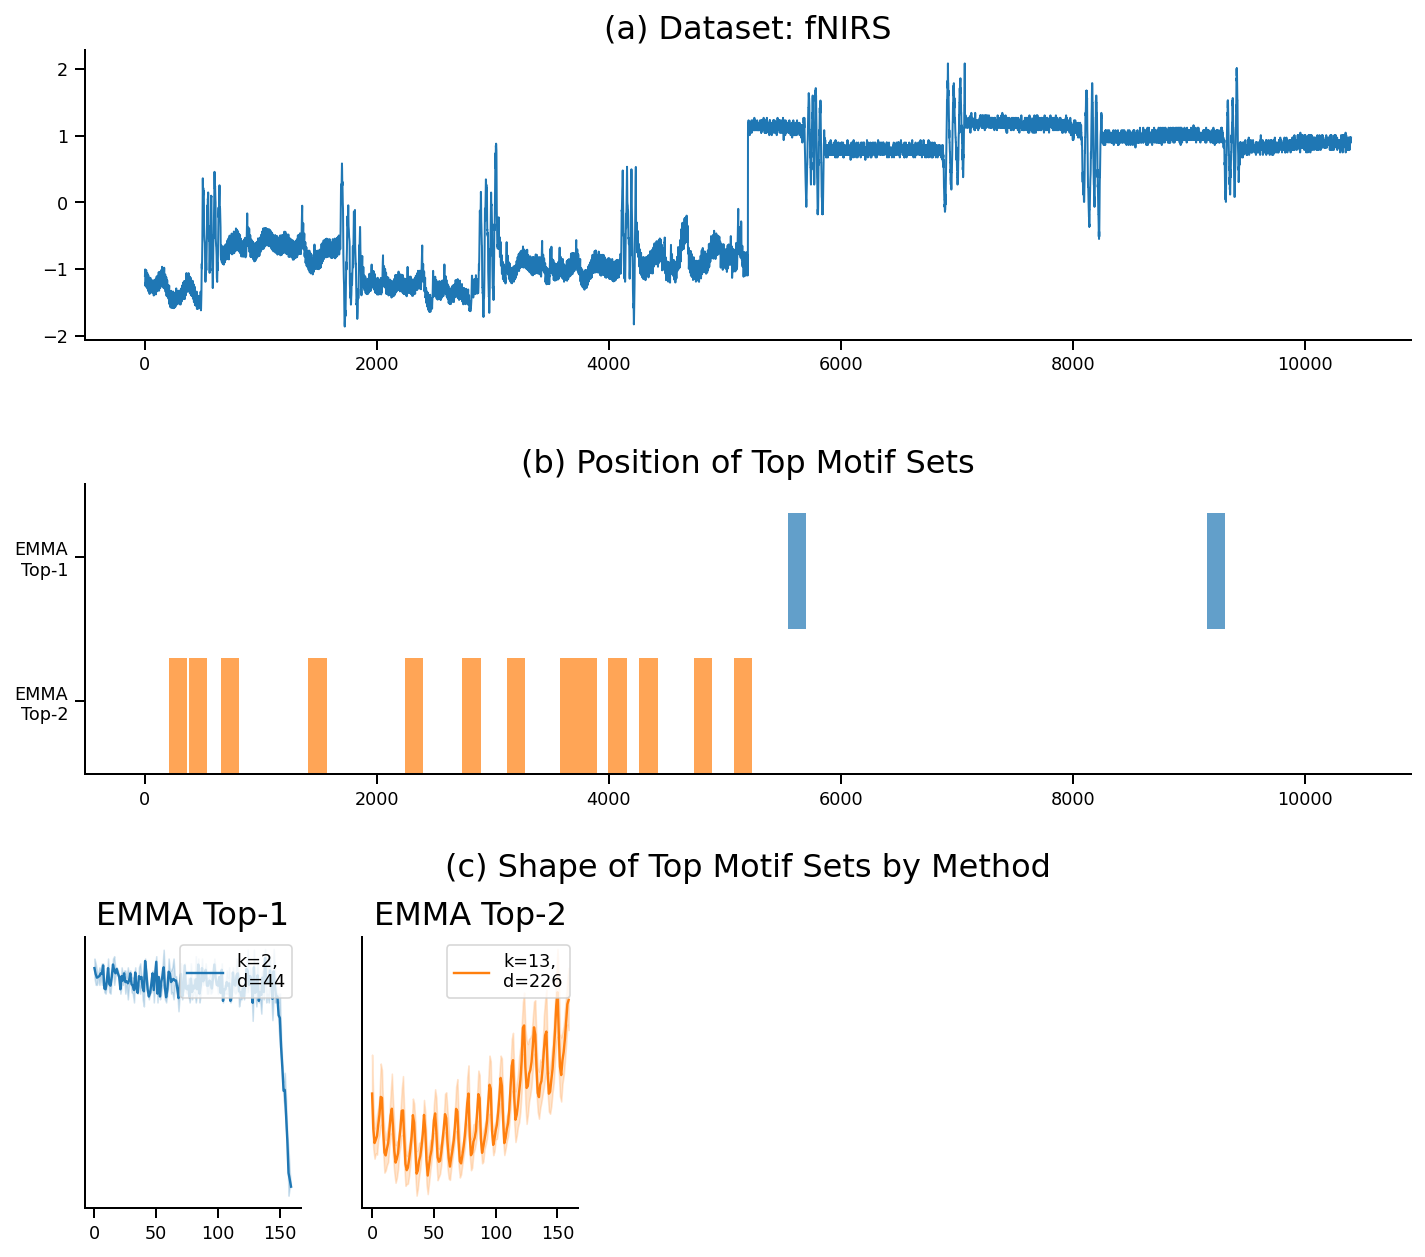

In [10]:
# run jave code first       
ms_emma = [
    [5541, 9157],
	[208, 376, 653, 1410, 2240, 2738, 3120, 3578, 3737, 3996, 4262, 4732, 5078],
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA")

df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_emma, "EMMA", D_full)

# Valmod Motif Sets
based on own (fixed-length) implementation

r: 17.806209564208984 d: 17.806209564208984
r: 24.650550842285156 d: 29.587139129638672
r: 66.71025848388672 d: 113.32780456542969
r: 39.262535095214844 d: 60.28601837158203
r: 104.20896911621094 d: 139.46177673339844
Filtered Elbow Points [1, 2, 3]


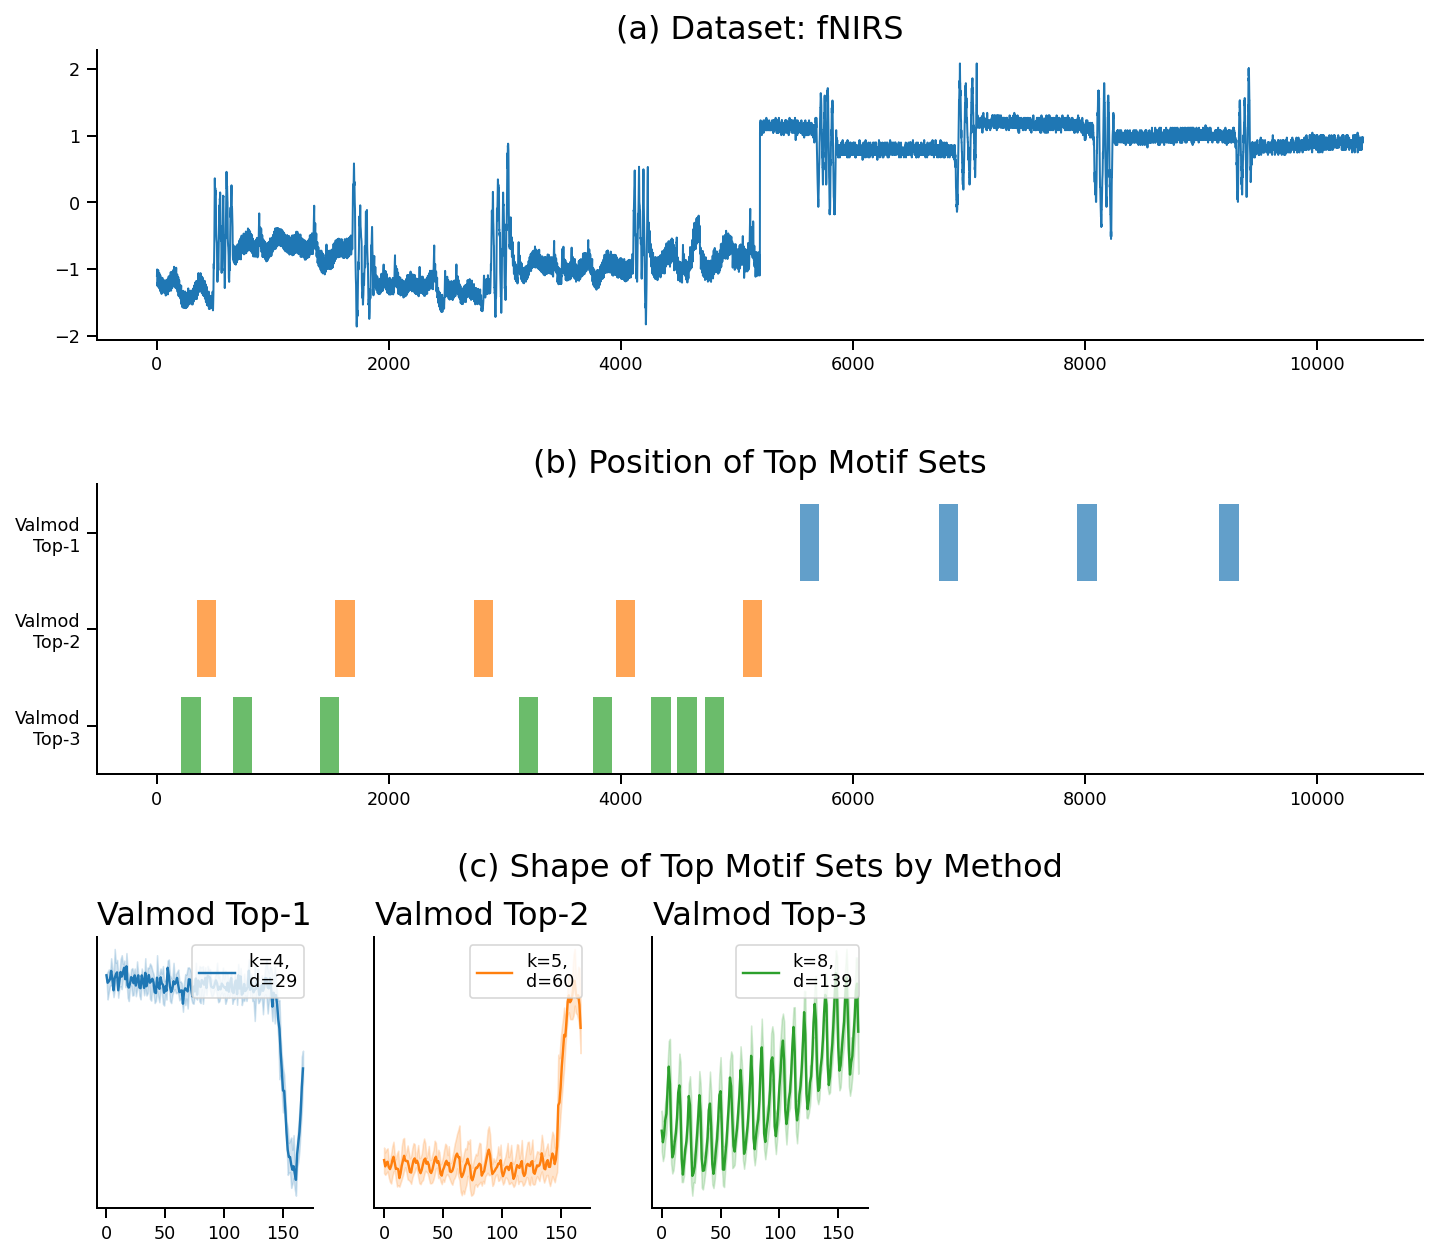

In [11]:
ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=rs[-1]))
motifset = plot_competitors(series, ds_name, ms_valmod, 
                            mls, prefix="Valmod")

df["VALMOD Top-1"] = [motifset[-1]]
df2["VALMOD Top-2"] = [motifset[-3]]
df_comp = append_all_motif_sets(df_comp, ms_valmod, "VALMOD", D_full)

# Learning Motifs
See Java Code

In [12]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs+1)),
       str(mls)])

r: 22.086715698242188 d: 22.086715698242188
r: 305.5087890625 d: 353.1971740722656
Filtered Elbow Points [0, 1]


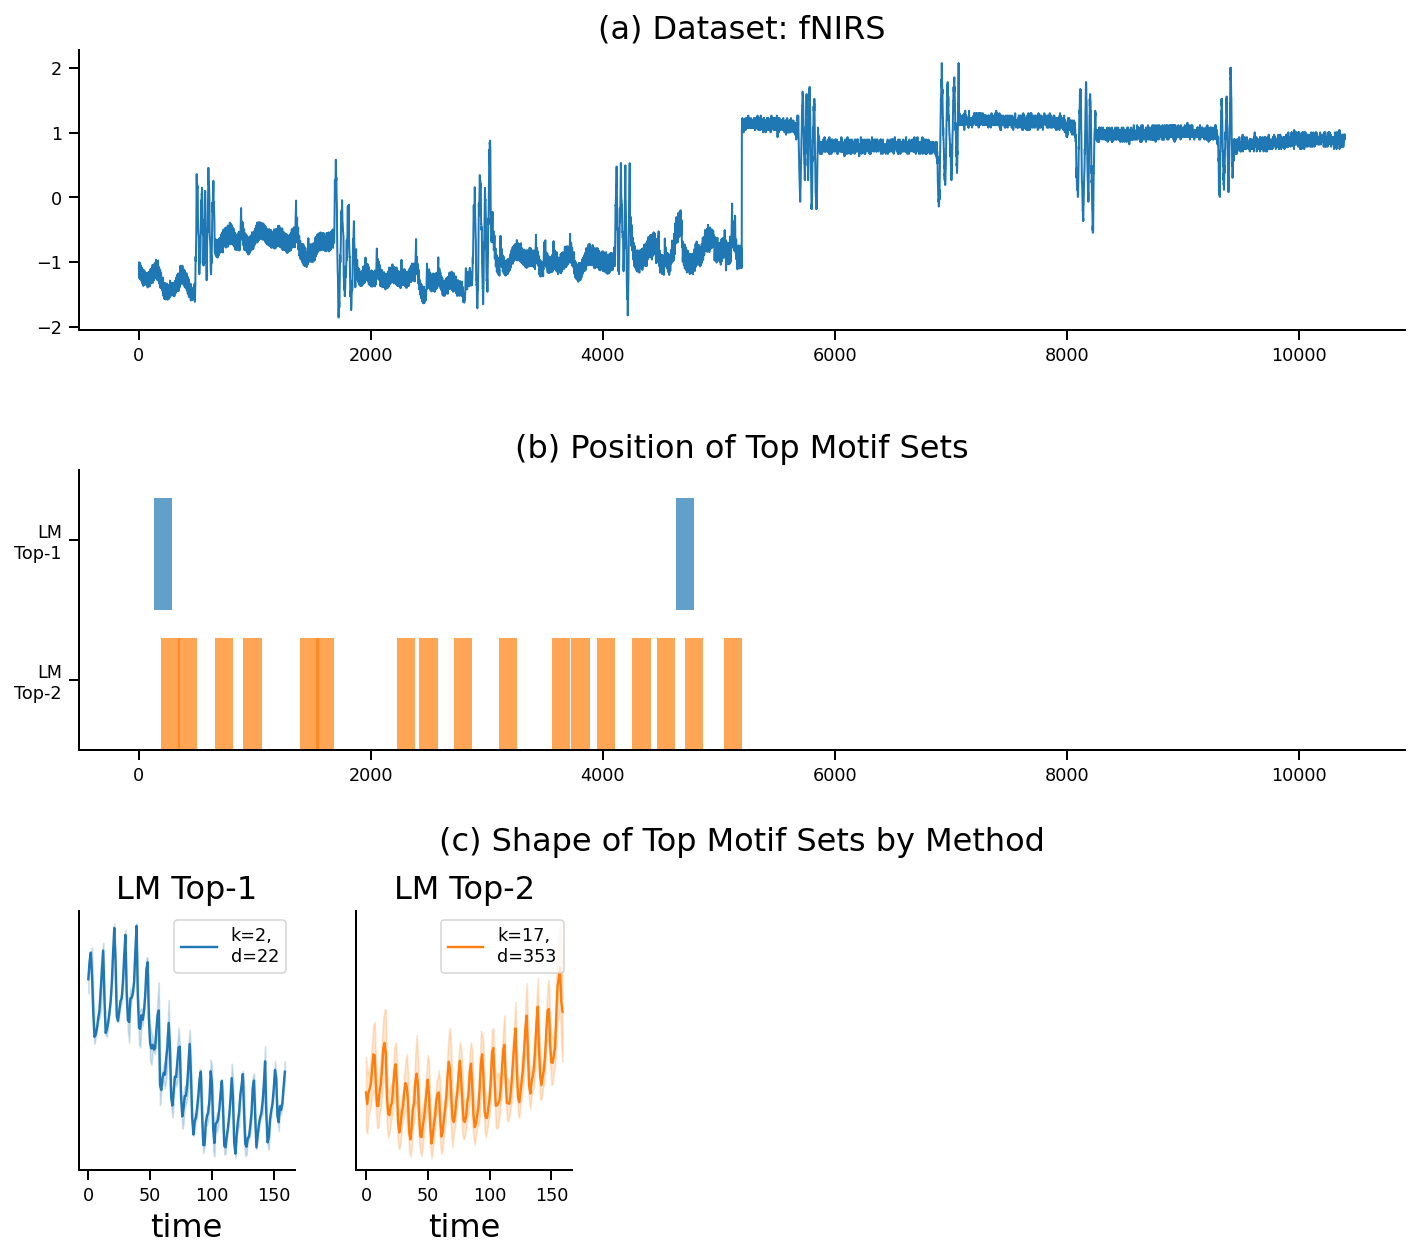

In [13]:
ms_learning_motifs = np.array([
    [127,4632,],
	[193,342,655,899,1393,1525,2224,2417,2714,3103,3562,3730,3951,4255,4467,4708,5046,],
])

    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, motif_length, prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df2["LM Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_learning_motifs, "LM", D_full)

# Comparison

In [14]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

,offsets
Motiflets Top-1,"[219, 4742, 1411, 4486, 3121, 3579, 4272, 908,..."
Set Finder Top-1,"[4486, 351, 654, 1394, 1542, 2215, 2434, 2735,..."
EMMA Top-1,"[208, 376, 653, 1410, 2240, 2738, 3120, 3578, ..."
VALMOD Top-1,"[210, 654, 1402, 3121, 3756, 4263, 4486, 4725]"
LM Top-1,"[193, 342, 655, 899, 1393, 1525, 2224, 2417, 2..."
Motiflets Top-2,"[5548, 6744, 7937, 9164]"
Set Finder Top-2,"[6739, 9159]"
EMMA Top-2,"[5541, 9157]"
VALMOD Top-2,"[5543, 6740, 7936, 9160]"
LM Top-2,"[127, 4632]"


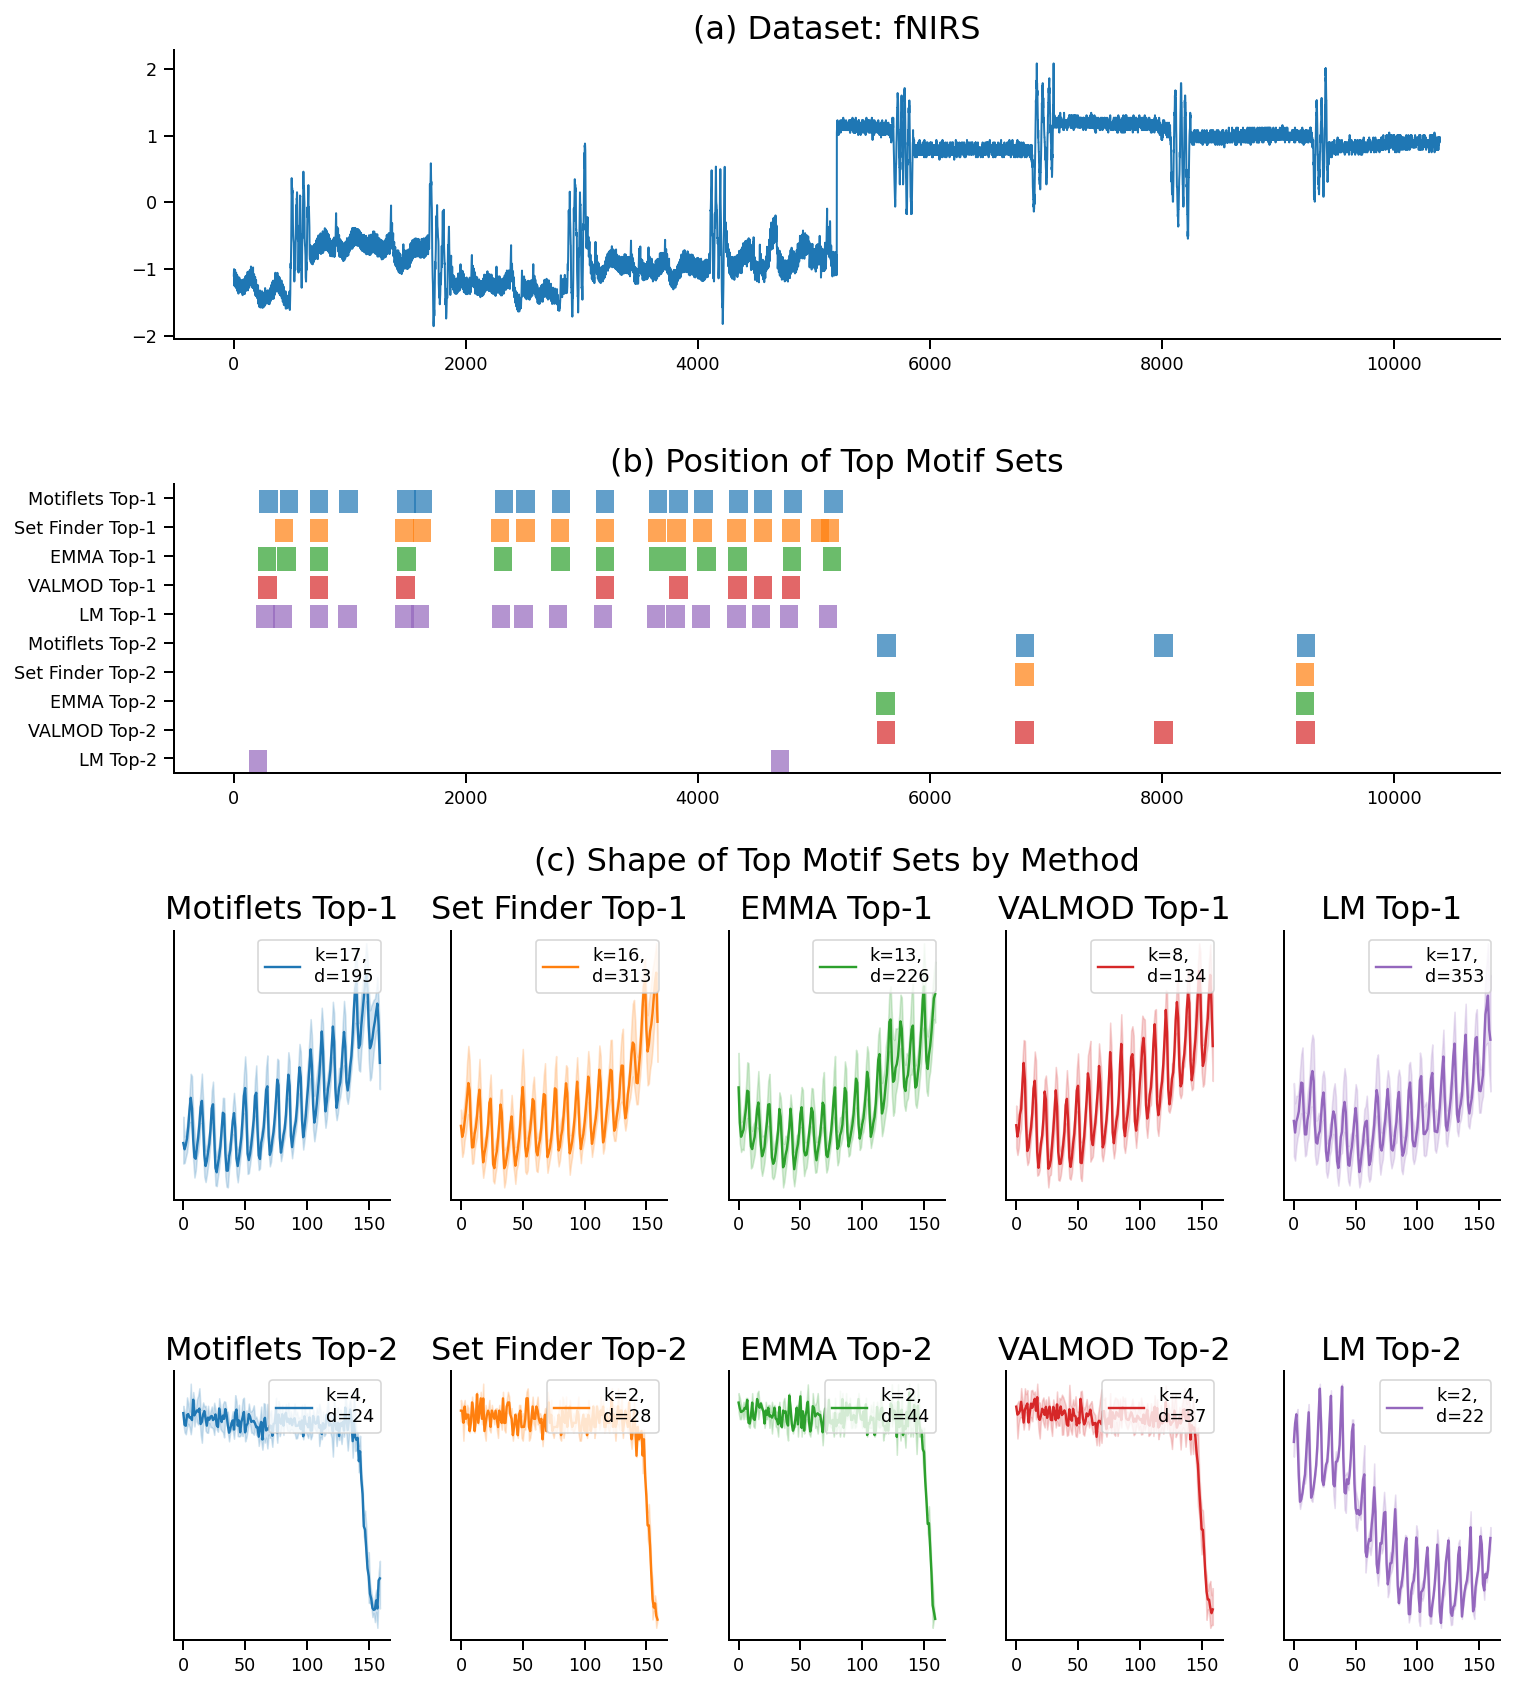

In [15]:
motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values)